In [1]:
 # These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../../..")
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cuda"

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'/tmp/try_flags_7qlj7rb8.c:4:10: fatal error: cudnn.h: No such file or directory\n #include <cudnn.h>\n          ^~~~~~~~~\ncompilation terminated.\n'
Mapped name None to device cuda: GeForce RTX 2080 (0000:01:00.0)


## Model definition

In the previous example we assume constant thickness to be able to reduce the problem to one dimension. This keeps the probabilistic model fairly simple since we do not need to deel with complex geometric structures. Unfortunaly, geology is all about dealing with complex three dimensional structures. In the moment data spread across the physical space, the probabilistic model will have to expand to relate data from different locations. In other words, the model will need to include either interpolations, regressions or some other sort of spatial functions. In this paper, we use an advance universal co-kriging interpolator. Further implications of using this method will be discuss below but for this lets treat is a simple spatial interpolation in order to keep the focus on the constraction of the probabilistic model.

In [2]:
geo_model = gp.create_model('2-layers')
gp.init_data(geo_model, extent=[0, 10000, 0, 10000, 0, 10000], resolution=[500,1,500])

Active grids: ['regular']


2-layers  2019-10-15 11:08

In [3]:
geo_model.add_surfaces('surface 1')
geo_model.add_surfaces('surface 2')
geo_model.add_surfaces('basement')
dz = geo_model.grid.regular_grid.dz
geo_model.surfaces.add_surfaces_values([dz, 0, 0], ['dz'])
geo_model.surfaces.add_surfaces_values([2.6, 2.4, 3.2], ['density'])

,surface,series,order_surfaces,isBasement,color,id,dz,density
0,surface 1,Default series,1,False,#015482,1,20,2.6
1,surface 2,Default series,2,False,#9f0052,2,0,2.4
2,basement,Default series,3,True,#ffbe00,3,0,3.2


In [4]:
geo_model.add_surface_points(3000, 5000, 3000, 'surface 1')
geo_model.add_surface_points(7000, 5000, 3000, 'surface 1')

geo_model.add_surface_points(3000, 5000, 6000, 'surface 2')
geo_model.add_surface_points(7000, 5000, 6000, 'surface 2')

geo_model.add_orientations(5000, 5000, 10000, 'surface 1', [0,0,1])

,X,Y,Z,X_r,Y_r,Z_r,G_x,G_y,G_z,dip,azimuth,polarity,surface,series,id,order_series,smooth
0,5000.0,5000.0,10000.0,0.5001,0.5001,0.7501,0.0,0.0,1.0,0.0,0.0,1.0,surface 1,Default series,1,1,0.01


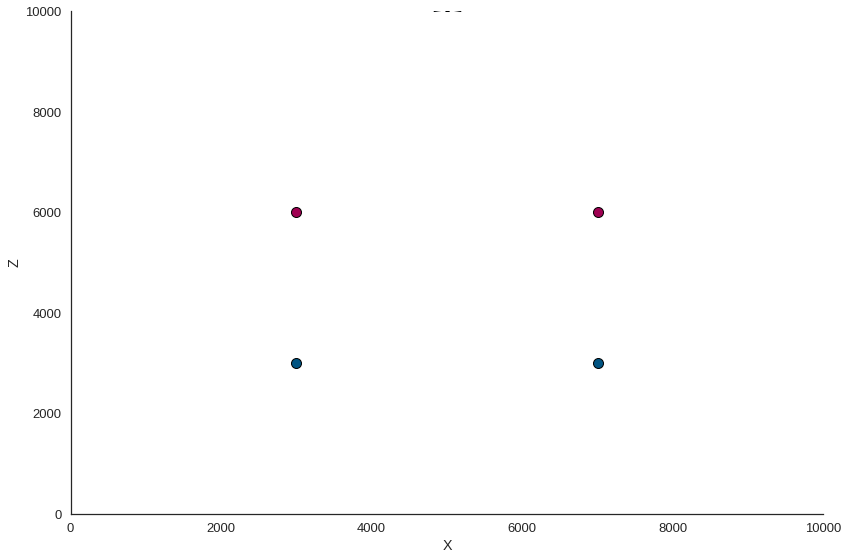

In [5]:
gp.plot.plot_data(geo_model)

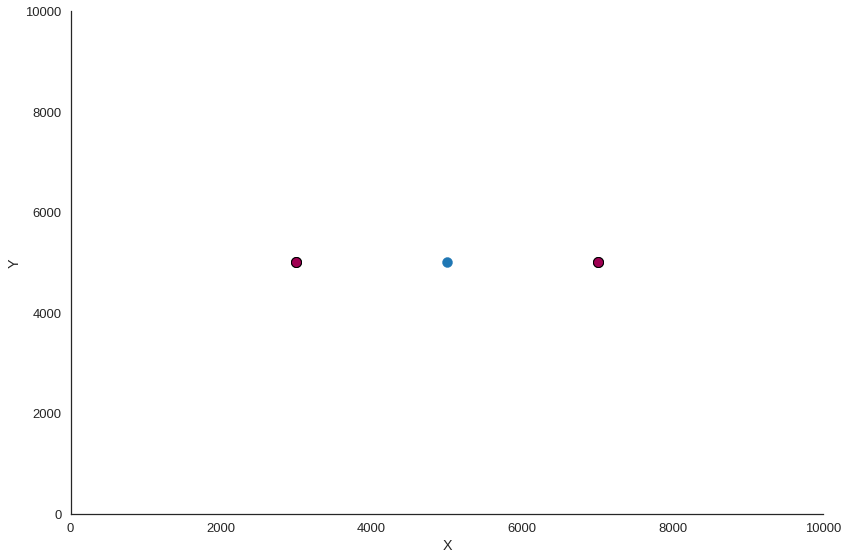

In [6]:
device_loc = np.array([[5000,5000,10000]])
import matplotlib.pyplot as plt
gp.plot.plot_data(geo_model, direction='z')
plt.scatter(device_loc[:,0], device_loc[:, 1], s=100)

In [7]:
geo_model.set_centered_grid(device_loc,  resolution = [10, 10, 15], radio=16000)

Active grids: ['regular' 'centered']


Grid Object. Values: 
array([[ 1.00000000e+01,  1.00000000e+01,  1.00000000e+01],
       [ 1.00000000e+01,  1.00000000e+01,  3.00000000e+01],
       [ 1.00000000e+01,  1.00000000e+01,  5.00000000e+01],
       ...,
       [ 2.10000000e+04,  2.10000000e+04, -9.04591384e+02],
       [ 2.10000000e+04,  2.10000000e+04, -4.77796492e+03],
       [ 2.10000000e+04,  2.10000000e+04, -1.01600000e+04]])

In [8]:
geo_model.additional_data.options.modify_options('dtype', 'float32')

,dtype,output,theano_optimizer,device,verbosity
values,float32,geology,fast_compile,cpu,[]


In [9]:
gp.set_interpolator(geo_model, type='grav', pos_density=2,  gradient=True,
                    theano_optimizer='fast_run')            

Interpolator object upgraded from InterpolatorModel to InterpolatorGravity.
Calculating the tz components for the centered grid...
Done
Compiling theano function...
Compilation Done!


In [10]:
geo_model.interpolator.theano_graph.gradient 

True

In [11]:
geo_model.grid.active_grids

array([ True, False, False, False,  True])

In [12]:
gp.compute_model(geo_model, output='gravity', set_solutions=True)

Active grids: ['regular' 'centered']


../../../../gempy/core/solution.py:259: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.. The surface is: Series: Input array must be at least 2x2x2.; Surface Number:0
  '; Surface Number:' + str(s_n))
../../../../gempy/core/solution.py:259: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.. The surface is: Series: Input array must be at least 2x2x2.; Surface Number:1
  '; Surface Number:' + str(s_n))



Lithology ids 
  [3.008557   3.0085285  3.0085     ... 0.9900714  0.99004287 0.9900143 ] 

In [13]:
# Reset
grav= [] 

In [14]:
def plot(z1, z2):
    geo_model.modify_surface_points([2,3], Z=z1)
    geo_model.modify_surface_points([0,1], Z=z2)
    gp.compute_model(geo_model, output='gravity')
    grav.append(geo_model.solutions.fw_gravity)
    #geo_model.set_active_grid(['regular'])
    #gp.compute_model(geo_model)
    gp.plot.plot_section(geo_model, 0, show_data=True, direction='y')
    plt.scatter(geo_model.grid.centered_grid.values[:, 0], geo_model.grid.centered_grid.values[:, 2],
               c='k', s= 3)
    plt.show()
    plt.plot(grav, 'o')
    plt.ylabel('grav')
    plt.show()


### Genereate your own observations!

In [15]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interact(plot, z1=(1000, 6000, 200), z2=(5000, 9999, 200))

interactive(children=(IntSlider(value=3400, description='z1', max=6000, min=1000, step=200), IntSlider(value=7…

<function __main__.plot(z1, z2)>

In [16]:
g_stats = np.asarray(grav)
g_stats.mean(), g_stats.std()

(-16442.3, 0.0)

In [17]:
g_stats.reshape(-1)

array([-16442.3], dtype=float32)

_____
### Bayesian

In [18]:
from gempy.bayesian.plot_posterior import default_blue

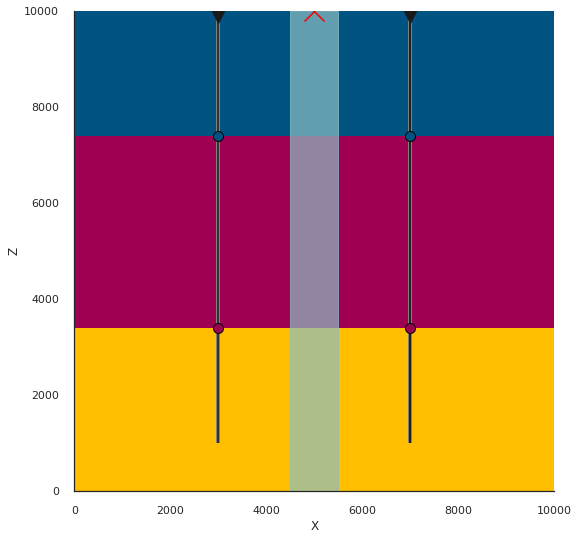

In [19]:
p = gp.plot.plot_section(geo_model, 0, show_data=True, direction='y')
p.fig.axes[-1].scatter([3*1000], [9.9*1000],  marker='v', s =200, c='k',zorder=10)
p.fig.axes[-1].scatter([7*1000], [9.9*1000],  marker='v', s =200, c='k', zorder=10)
p.fig.axes[-1].scatter([5*1000], [10*1000],  marker='x', s =400, c='red',zorder=10)

p.fig.axes[-1].vlines(3*1000, 1*1000, 10*1000, linewidth=4, color='gray', )
p.fig.axes[-1].vlines(7*1000, 1*1000, 10*1000, linewidth=4, color='gray')
p.fig.axes[-1].vlines(3*1000, 1*1000, 10*1000)
p.fig.axes[-1].vlines(7*1000, 1*1000, 10*1000)
p.fig.axes[-1].vlines(7*1000, 1*1000, 10*1000)
p.fig.axes[-1].fill_between(x=[4.5*1000,5.5*1000], y1=[0,0], y2=[10*1000,10*1000], alpha=.7, color=default_blue)

### Setting gempy into a pymc function


In [21]:
geo_model.interpolator.theano_graph.sig_slope.set_value(150)

In [66]:
# # Test gradient
# import theano
# import theano.tensor as tt
# theano.config.compute_test_value = 'ignore'
# geo_model_T = theano.OpFromGraph(geo_model.interpolator.theano_graph.input_parameters_loop,
#                                 [theano.grad(geo_model.interpolator.theano_graph.compute_series()[0][1][0:250000].sum(),
#                                              geo_model.interpolator.theano_graph.input_parameters_loop[4])], inline=True,
#                                  on_unused_input='ignore',
#                                  name='geo_model')

# import theano
# import theano.tensor as tt
theano.config.compute_test_value = 'ignore'
geo_model_T = theano.OpFromGraph(geo_model.interpolator.theano_graph.input_parameters_grav,
                                [theano.grad(geo_model.interpolator.theano_graph.compute_forward_gravity(densities=None, pos_density=2)[-1][0],
                                             geo_model.interpolator.theano_graph.input_parameters_grav[4])], inline=True,
                                 on_unused_input='ignore',
                                 name='forw_grav')

i = geo_model.interpolator.get_python_input_grav()
th_f = theano.function([], geo_model_T(*i), on_unused_input='warn')
th_f()

array([[    0.     ,     0.     ,   457.56787],
       [    0.     ,     0.     ,   457.5744 ],
       [    0.     ,     0.     , -1633.6165 ],
       [    0.     ,     0.     , -1633.6177 ]], dtype=float32)

In [71]:
theano.config.compute_test_value = 'ignore'
geo_model_T = theano.OpFromGraph(geo_model.interpolator.theano_graph.input_parameters_grav,
                                [geo_model.interpolator.theano_graph.compute_forward_gravity(densities=None, pos_density=2)[-1]],
                                 inline=True,
                                 on_unused_input='ignore',
                                 name='forw_grav')
th_f = theano.function([], geo_model_T(*i), on_unused_input='warn')


array([-15766.664], dtype=float32)

In [64]:
th_f()

array([-15766.664], dtype=float32)

In [72]:
# We convert a python variable to theano.shared
input_sh = []
i = geo_model.interpolator.get_python_input_grav()
for ii in i:
    input_sh.append(theano.shared(ii))

# We get the rescaling parameters:
rf = geo_model.rescaling.df.loc['values', 'rescaling factor']
centers = geo_model.rescaling.df.loc['values', 'centers']

# We create pandas groups by id to be able to modify several points at the same time:
g = geo_model.surface_points.df.groupby('id')
l = theano.shared(np.array([], dtype='float32'))

In [73]:
g_stats = np.array([-15620.198, -15620.198, -16052.367, -16052.367, -16052.367,
       -16052.367, -16052.367, -16052.367, -16052.367, -16052.367,
       -16052.367, -16052.367, -16052.367, -16052.367, -15620.198,
       -15620.198, -15620.198, -15620.198, -15620.198, -16052.367,
       -16052.367, -16052.367, -16052.367, -16163.165, -16163.165,
       -16163.165, -16099.716, -16099.716, -16099.716, -16163.165,
       -16163.165, -16163.165, -16163.165, -16163.165, -16163.165,
       -16163.165, -16099.716, -16099.716, -16099.716, -16163.165,
       -16163.165, -16163.165, -16099.716, -16099.716, -16099.716,
       -16099.716, -16099.716, -16099.716, -16099.716, -16163.165,
       -16099.716, -16099.716, -16099.716, -16099.716, -16052.367,
       -16099.716, -16099.716, -16099.716, -16099.716, -16163.165,
       -16163.165, -16163.165, -16099.716, -16099.716, -16099.716,
       -16163.165, -16163.165], dtype='float32')

In [74]:
## theano.config.compute_test_value = 'ignore'

with pm.Model() as model:
    depths = pm.Normal('depths', geo_model.surface_points.df['Z'], np.array([1000,1000,1000,1000]), shape=4)
    depths_r = (depths - centers[2])/rf + 0.5001
    input_sh[4] =  tt.set_subtensor(input_sh[4][:, 2], depths_r)
    grav = geo_model_T(*input_sh)
    
    # well = geo.reshape((500,1,500))[250, 0 ,:]
    #thickness = pm.Deterministic('thickness', well.sum())
    grav = pm.Deterministic('gravity', grav)
    
 #   sigma = pm.Gamma('$\sigma$', 1, .7)
    sigma = pm.Deterministic('$\sigma$', theano.shared(np.array(250)))
 #   sigma = pm.Normal('$\sigma$', 5, 1)
    obs_grav = pm.Normal('y', mu=grav[0], sd=sigma, observed=g_stats)



In [75]:
with model:
    trace = pm.sample(100, chains=1, tune=20, discard_tuned_samples=False,
                  compute_convergence_checks=False)
    prior = pm.sample_prior_predictive(1000)
    post = pm.sample_posterior_predictive(trace)


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
ERROR (theano.gof.opt): SeqOptimizer apply <theano.gpuarray.opt.GraphToGPU object at 0x7ff09c527828>
ERROR (theano.gof.opt): Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/miguel/.conda/envs/m_gempy/lib/python3.7/site-packages/theano/gof/opt.py", line 251, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/miguel/.conda/envs/m_gempy/lib/python3.7/site-packages/theano/gof/opt.py", line 97, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/home/miguel/.conda/envs/m_gempy/lib/python3.7/site-packages/theano/gpuarray/opt.py", line 429, in apply
    outputs = new_ops(*[mapping[i] for i in node.inputs], return_list=True)
  File "/home/miguel/.conda/envs/m_gempy/lib/python3.7/site-packages/theano/gof/op.py", line 615, in __call__
    node = self.make_node(*inputs, **kwargs)
  File "/home/miguel/.conda/envs/m_gempy/lib/python3

In [76]:
import arviz as az

data = az.from_pymc3(trace=trace,
                     prior=prior,
                     posterior_predictive=post)
data.posterior

<xarray.Dataset>
Dimensions:        (chain: 1, depths_dim_0: 4, draw: 120, gravity_dim_0: 1)
Coordinates:
  * chain          (chain) int64 0
  * draw           (draw) int64 0 1 2 3 4 5 6 7 ... 113 114 115 116 117 118 119
  * depths_dim_0   (depths_dim_0) int64 0 1 2 3
  * gravity_dim_0  (gravity_dim_0) int64 0
Data variables:
    depths         (chain, draw, depths_dim_0) float32 7280.7173 ... 4269.7793
    gravity        (chain, draw, gravity_dim_0) float32 -15787.911 ... -16042.627
    $\sigma$       (chain, draw) int64 250 250 250 250 250 ... 250 250 250 250
Attributes:
    created_at:                 2019-10-15T09:38:00.203906
    inference_library:          pymc3
    inference_library_version:  3.7

In [30]:
data.prior['foo2'] = data.prior['depths'][0 ,:, 0]
data.prior['foo3'] = data.prior['depths'][0 ,:, 1]

In [31]:
data.posterior['foo2'] =  data.posterior['depths'][0 ,:, 0]
data.posterior['foo3'] =  data.posterior['depths'][0 ,:, 1]
data.posterior['foo4'] =  data.posterior['depths'][0 ,:, 2]
data.posterior['foo5'] =  data.posterior['depths'][0 ,:, 3]

In [32]:
data.posterior['like_std2'] = np.array([5]*200)

In [ ]:
az

In [ ]:
2

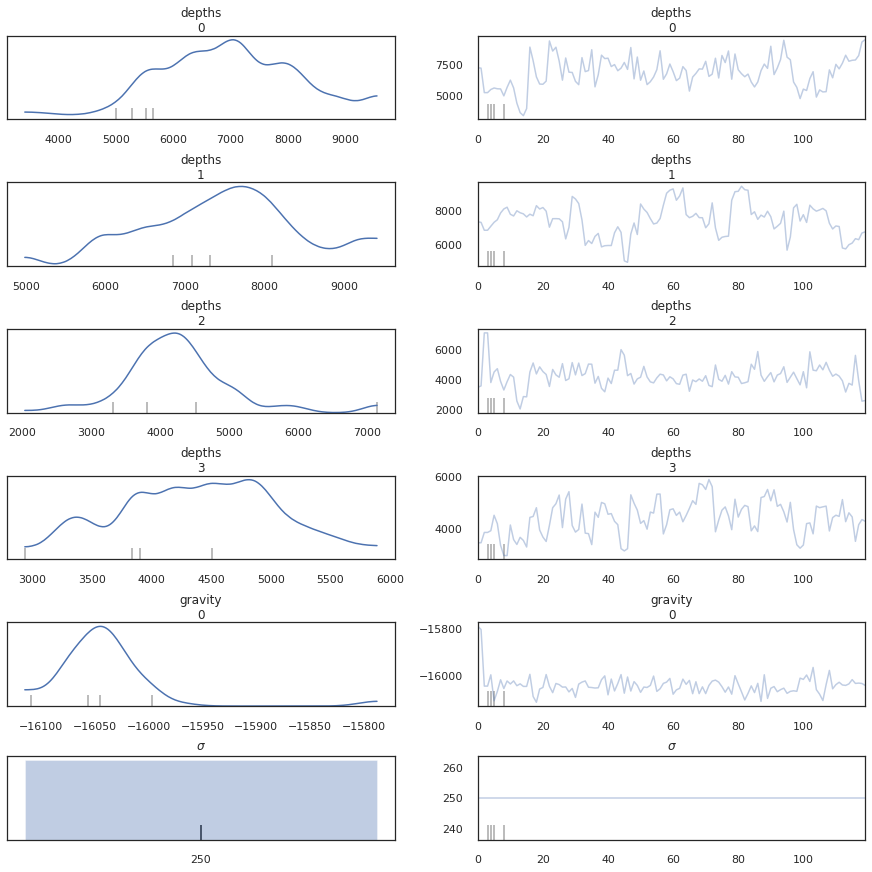

In [77]:
az.plot_trace(data);


In [ ]:
az.plot_joint(data, var_names=['foo2', 'foo3'])

In [ ]:
# !git pull
from gempy.bayesian import plot_posterior as pp

import seaborn as sns


In [ ]:
%matplotlib notebook
from importlib import reload
reload(pp)
p = pp.PlotPosterior(data)
p.create_figure(figsize=(9,3), joyplot=True)

In [ ]:
def change_iteration(iteration):
    p.plot_posterior(['foo2', 'foo3'], ['thickness', '$\sigma$'], 'y', iteration)
    # p.plot_posterior(['$\mu$', '$\sigma$'], ['$\mu$', '$\sigma$'], 'y', iteration)

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interact(change_iteration, iteration=(0, 200, 1))

In [ ]:
from gempy.bayesian.plot_posterior import my_cmap_full

In [ ]:
az.plot_pair(data, divergences=True, var_names=['foo2', 'foo3', '$\sigma$'], kind='kde', contour=True,
            colorbar=True)
             #plot_kwargs={'cmap':my_cmap_full});